In [1]:
import os
import numpy as np
import firedrake as fd
import matplotlib.pyplot as plt
import hydrogym.firedrake as hgym
import ufl
from scipy import linalg

from lti_system import control_vec, measurement_matrix
from step_response import LinearBDFSolver

Re = 100
eig_dir = f"../re{Re}_med_eig_output"

In [2]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{eig_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


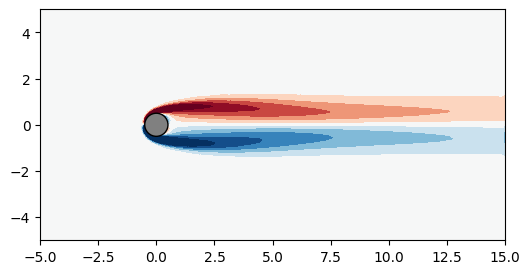

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


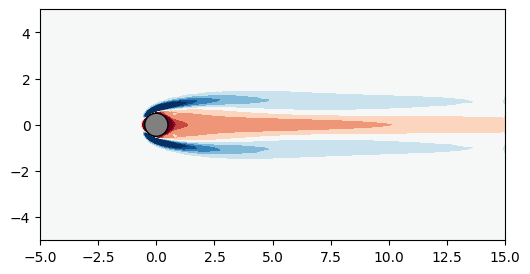

In [4]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure
qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


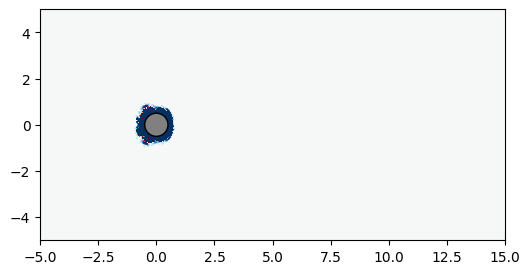

In [5]:
# 3. Derive the "measurement matrix"
# This is a field qM such that the inner product of qM with the flow field
# produces the same result as computing the observation (lift coefficient)

qM = measurement_matrix(flow)

flow.q.assign(qM)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

# Load unstable global modes

In [6]:
evals = np.load(f"{eig_dir}/evals.npy")

# Load the set of eigenvectors
V_global = []
with fd.CheckpointFile(f"{eig_dir}/evecs.h5", "r") as chk:
    for i in range(len(evals)):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V_global.append(q)

W_global = []
with fd.CheckpointFile(f"{eig_dir}/adj_evecs.h5", "r") as chk:
    for i in range(len(evals)):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W_global.append(q)

# Sort by descending real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V_global = [V_global[i] for i in sort_idx]
W_global = [W_global[i] for i in sort_idx]

# Keep only the unstable modes
unstable_idx = np.where(evals.real > 0)[0]
V_global = [V_global[i] for i in unstable_idx]
W_global = [W_global[i] for i in unstable_idx]

ru = len(unstable_idx)  # Number of unstable modes

# Load impulse response data

In [7]:
snapshot_dir = "impulse_output"

# Direct impulse response solution
X = []
m_d = 100  # Number of direct snapshots
with fd.CheckpointFile(f"{snapshot_dir}/re100_dir_response.h5", "r") as chk:
    for i in range(m_d):
        q = chk.load_function(flow.mesh, f"q_{i}")
        X.append(q)

# Adjoint impulse response solution
Y = []
m_a = 100  # Number of adjoint snapshots
with fd.CheckpointFile(f"{snapshot_dir}/re100_adj_response.h5", "r") as chk:
    for i in range(m_a):
        q = chk.load_function(flow.mesh, f"q_{i}")
        Y.append(q)



[[ 0.00000000e+00  7.33505535e-01  8.09225774e-03]
 [ 1.00000000e-02  1.68098203e+00 -1.41383847e-03]
 [ 2.00000000e-02  1.67946119e+00 -1.20308845e-04]
 ...
 [ 2.99960000e+02  3.14913693e-05  2.44409158e-05]
 [ 2.99970000e+02 -6.13854456e-06  2.31090341e-05]
 [ 2.99980000e+02  4.38467091e-05  9.39290385e-06]]


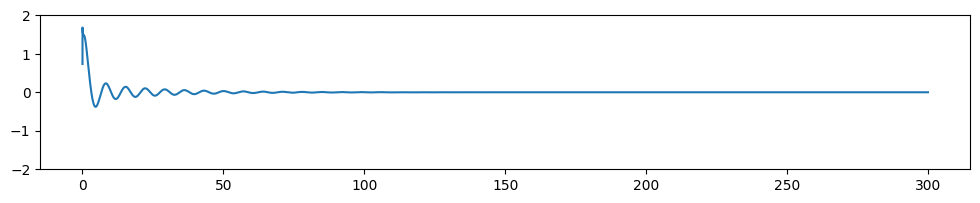

In [59]:
# Load data from model_reduction/step_response.py
step_response = np.load("impulse_output/re100_long_response.npy")
print(step_response)
t, y = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, y, label="Full operator")
# ax.plot(t_full, CL_full, label="Full operator")
# ax.plot(np.arange(0, tf-dt, dt), CL, label="Stable subspace")
ax.set_ylim([-2, 2])
# ax.set_xlim([0, 100])
plt.show()

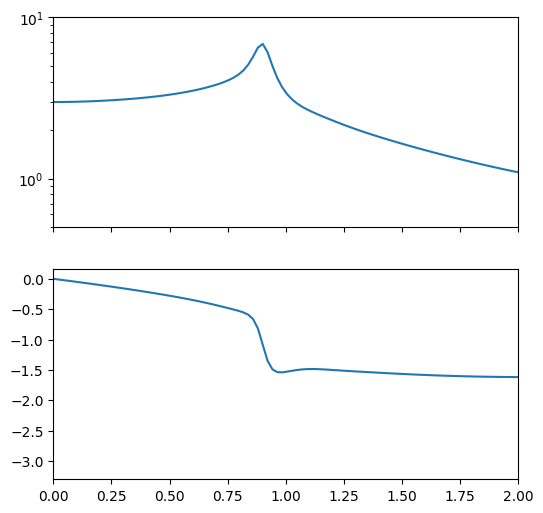

In [62]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(y)
f_dns = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
H_dns = np.sqrt(1 / 2 * np.pi) * np.fft.fft(y) / fs
# 
# H_dns = H_dns / H_dns[0]

f_dns = f_dns[:n//2]
H_dns = H_dns[:n//2]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f_dns, np.abs(H_dns))
ax[0].set_ylim(0.5, 10)
ax[1].plot(f_dns, np.angle(H_dns))
ax[1].set_xlim(0, 2)
plt.show()


# BPOD

In [8]:
# Method of snapshots
R = np.zeros((m_a, m_a))
for i in range(m_a):
    for j in range(m_d):
        R[i, j] = flow.inner_product(X[j], Y[i]).real

(0.0, 20.0)

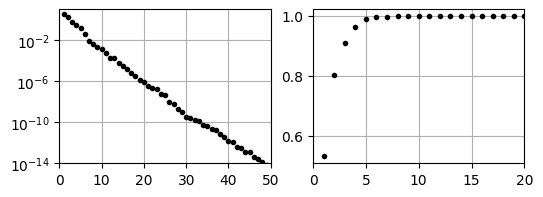

In [9]:
U, S, T = linalg.svd(R)

# Plot Hankel singular values
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].semilogy(1 + np.arange(len(S)), S, 'k.')
ax[0].set_xlim([0, 50])
ax[0].set_ylim([1e-14, 1e1])
ax[0].grid()
ax[1].plot(1 + np.arange(len(S)), np.cumsum(S) / np.sum(S), 'k.')
ax[1].grid()
ax[1].set_xlim([0, 20])

In [233]:
V_bpod = []   # direct modes: X @ T.T @ S ** (-1/2)
W_bpod = []   # adjoint modes: Y @ U @ S ** (-1/2)

rs = 8  # Number of BPOD modes for stable subspace
for i in range(rs):
    psi = fd.Function(flow.mixed_space)
    for j in range(m_d):
        psi.assign(psi + X[j] * T[i, j] / np.sqrt(S[i]))
    V_bpod.append(psi)

    psi = fd.Function(flow.mixed_space)
    for j in range(m_a):
        psi.assign(psi + Y[j] * U[j, i] / np.sqrt(S[i]))
    W_bpod.append(psi)


# Projection

In [234]:
r = ru + rs  # Total dimension of reduced-order model
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

V = V_global + V_bpod
W = W_global + W_bpod
for i in range(r):
    for j in range(r):
        # For the unstable subspace the matrix is diagonal
        if (i < ru) or (j < ru):
            Ar[j, i] = 0.0
            if i == j:
                Ar[j, i] = evals[unstable_idx[i]]
        else:
            Ar[j, i] = flow.inner_product(A @ V[i], W[j])

    Br[i, 0] = flow.inner_product(qC, W[i])
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

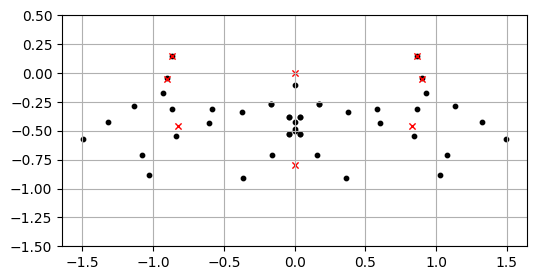

In [235]:
rom_evals = linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.set_ylim([-1.5, 0.5])
ax.grid()

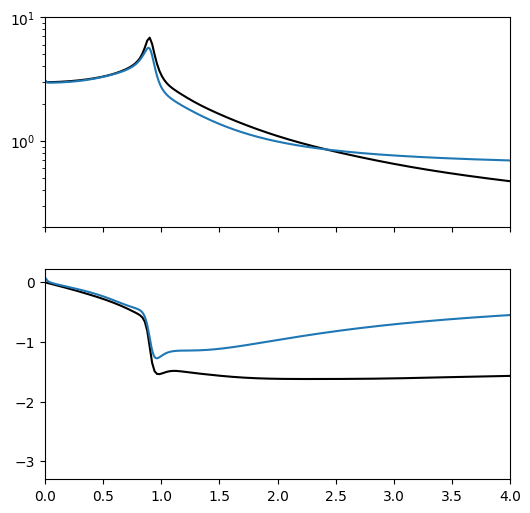

In [236]:
def H(s):
    return Cr @ np.linalg.inv(s * np.eye(r) - Ar) @ Br + Dr

omega = 1j * np.linspace(0.01, 4.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f_dns, np.abs(H_dns), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, omega[-1].imag)
ax[0].set_ylim(0.2, 10)
ax[1].plot(f_dns, np.angle(H_dns), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


# No control

In [237]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 50
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_nat[i], CD_nat[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.]
t=0.13, CL=0.0075, CD=-0.0000
   u=[0.]
t=0.14, CL=0.0073, CD=-0.0000
   u=[0.]
t=0.15, CL=0.0071, CD=-0.0000
   u=[0.]
t=0.16, CL=0.0069, CD=-0.0000
   u=[0.]
t=0.17, CL=0.0067, CD=-0.0000
   u=[0.]
t=0.18, CL=0.0065, CD=-0.0000
   u=[0.]
t=0.19, CL=0.0063, CD=-0.0000
   u=[0.]
t=0.20, CL=0.0062, CD=-0.0000
   u=[0.]
t=0.21, CL=0.0060, CD=-0.0000
   u=[0.]
t=0.22, CL=0.0058, CD=-0.0000
   u=[0.]
t=0.23, CL=0.0056, CD=-0.0000
   u=[0.]
t=0.24, CL=0.0054, CD=-0.0000
   u=[0.]


### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [238]:
m = 1
p = 1

Q = np.zeros((ru, ru))
R = np.eye(m)
P = linalg.solve_continuous_are(Ar[:ru, :ru], Br[:ru], Q, R)

K = np.zeros_like(Br.T)
Ku = linalg.solve(R, Br[:ru].T) @ P
K[:, :ru] = Ku

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

# Kalman filter
L = np.zeros_like(Cr.T)
Rf = np.eye(p)
Pf = linalg.solve_continuous_are(Ar[:ru, :ru].T.conj(), Cr[:, :ru].T.conj(), Q, Rf)
Lu = linalg.solve(Rf, Cr[:, :ru].conj()) @ Pf
L[:ru, :] = Lu.T

(0.0, 2.0)

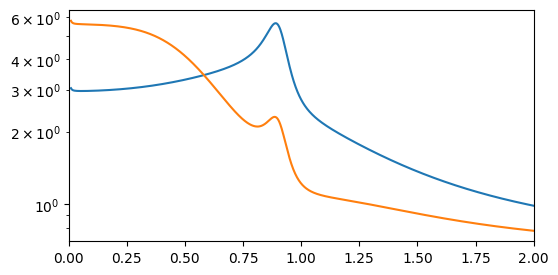

In [239]:
def H_cl(s):
    return Cr @ np.linalg.inv(s * np.eye(r) - (Ar - Br @ K)) @ Br + Dr

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
# ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [240]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis). 

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_lqr = np.zeros(n_steps)
CD_lqr = np.zeros(n_steps)

m = 1

z = np.zeros((n_steps, r), dtype=complex)  # Reduced state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        z[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

        # LQR control
        u[i] = np.real(K @ (z[i] - zC * rho[i-1]))

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_lqr[i], CD_lqr[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqr[i]:.4f}, CD={CD_lqr[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0087, CD=0.0000
   u=[-0.08348229], rho=[0.00083482]
t=0.02, CL=0.0076, CD=0.0000
   u=[-0.0816973], rho=[0.0016518]
t=0.03, CL=0.0065, CD=0.0000
   u=[-0.07980138], rho=[0.00244981]
t=0.04, CL=0.0055, CD=0.0000
   u=[-0.07786601], rho=[0.00322847]
t=0.05, CL=0.0045, CD=-0.0000
   u=[-0.07591508], rho=[0.00398762]
t=0.06, CL=0.0035, CD=-0.0000
   u=[-0.07395671], rho=[0.00472719]
t=0.07, CL=0.0026, CD=-0.0000
   u=[-0.07199375], rho=[0.00544713]
t=0.08, CL=0.0017, CD=-0.0000
   u=[-0.07002728], rho=[0.0061474]
t=0.09, CL=0.0008, CD=-0.0000
   u=[-0.06805784], rho=[0.00682798]
t=0.10, CL=-0.0000, CD=-0.0000
   u=[-0.06608574], rho=[0.00748883]
t=0.11, CL=-0.0009, CD=-0.0000
   u=[-0.06411126], rho=[0.00812995]
t=0.12, CL=-0.0017, CD=-0.0000
   u=[-0.06213462], rho=[0.00875129]
t=0.13, CL=-0.0025, CD=-0.0000
   u=[-0.06015606], rho=[0.00935285]
t=0.14, CL=-0.0032, CD=-0.0000
   u=[-0.05817582], rho=[0.00993461]
t=0.15, CL=-0.

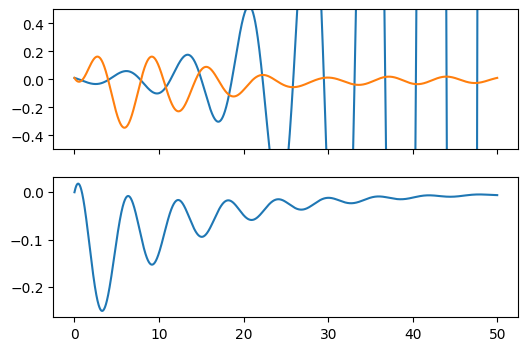

In [241]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_lqr)), CL_lqr)
ax[0].set_ylim([-0.5, 0.5])

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [242]:
dt = 0.01

# Zero-order hold discretization
A_kf = linalg.expm(Ar * dt)
B_kf = np.linalg.solve(Ar, (A_kf - np.eye(r))) @ Br
C_kf = Cr
D_kf = Dr

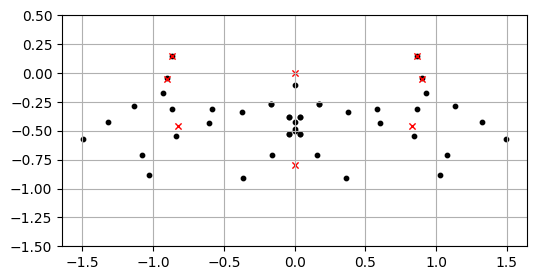

In [243]:
dt_evals = linalg.eigvals(A_kf)
ct_evals = np.log(dt_evals) / dt

# Compare the ct evals to the stability results
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(ct_evals.imag, ct_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.set_ylim([-1.5, 0.5])
ax.grid()

In [244]:
# # Forward Euler discretization
# A_kf = (Ar * dt + np.eye(r))
# B_kf = dt * Br
# C_kf = Cr
# D_kf = Dr

In [245]:
# Continuous Kalman filter

def design_lqe(A, C):
    Q = np.zeros_like(A)
    R = np.eye(C.shape[0])
    P = linalg.solve_continuous_are(A.T.conj(), C.T.conj(), Q, R)
    L = linalg.solve(R, C.conj()) @ P
    return L.T

L[:ru, :] = design_lqe(Ar[:ru, :ru], Cr[:, :ru])
Lu[:ru, :]

array([[10.85026608+19.80800398j, 10.85026608-19.80800398j]])

In [246]:
# Discrete Kalman filter

def design_dlqe(A, C, Q=None, R=None):
    if Q is None:
        Q = np.zeros_like(A)
    if R is None:
        R = np.eye(C.shape[0], dtype=C.dtype)
    P = linalg.solve_discrete_are(A.T.conj(), C.T.conj(), Q, R)
    L = linalg.solve(C @ P @ C.T.conj() + R, C @ P @ A.T.conj())
    return L.T.conj()

L = np.zeros_like(C_kf.T)
L[:ru, :] = design_dlqe(A_kf[:ru, :ru], C_kf[:, :ru])
L[:ru]

array([[0.14881802+0.21869796j],
       [0.14881802-0.21869796j]])

In [247]:
# Q = 1e-6 * np.eye(r)
# R = 1e-2 * np.eye(p)
# L = design_dlqe(A_kf, C_kf, Q, R)
# L

In [310]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 20.0

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

n_steps = int(tf // dt)
CL = np.zeros(n_steps)
CD = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL[i], CD[i] = map(np.real, flow.get_observations())

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Update the Kalman filter estimate 
    y[i] = CL[i]
    if i > 0:
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")
        print(f"   u={u[i]}, y={y[i]}, y_hat={y_hat[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], y=[0.00978918], y_hat=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.], y=[0.00963618], y_hat=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.], y=[0.00946944], y_hat=[5.82216835e-05]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.], y=[0.00929729], y_hat=[0.00011525]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.], y=[0.00912251], y_hat=[0.00017106]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.], y=[0.00894603], y_hat=[0.00022563]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.], y=[0.00876817], y_hat=[0.00027895]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.], y=[0.00858905], y_hat=[0.00033101]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.], y=[0.0084087], y_hat=[0.0003818]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.], y=[0.00822714], y_hat=[0.00043132]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.], y=[0.0080444], y_hat=[0.00047955]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.], y=[0.00786048], y_hat=[0.0005265]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.], y=[0.0076754], y_hat=[0.00057215]
t=0.13, CL=0.0075, CD=-0.0000

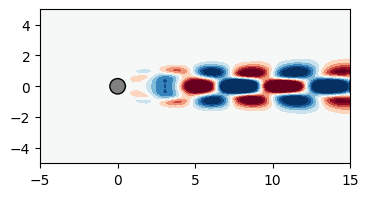

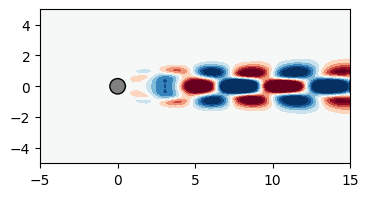

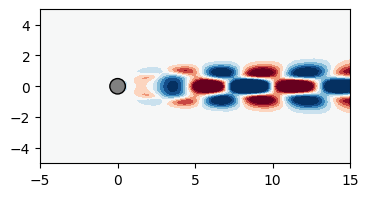

In [311]:
flow.q.assign(solver.q)

q1 = solver.q

# Reconstruction from reduced state
q2 = fd.Function(flow.mixed_space)
for i in range(r):
    q2.assign(q2 + V[i] * x[-1, i])

# Reconstruction from Kalman filter state
q3 = fd.Function(flow.mixed_space)
for i in range(r):
    q3.assign(q3 + V[i] * z[-1, i].conj())

for q in [q1, q2, q3]:
    flow.q.assign(q)
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    flow.render(axes=ax, clim=(-10, 10))
    ax.set_xlim([-5, 15])
    ax.set_ylim([-5, 5])
    plt.show()



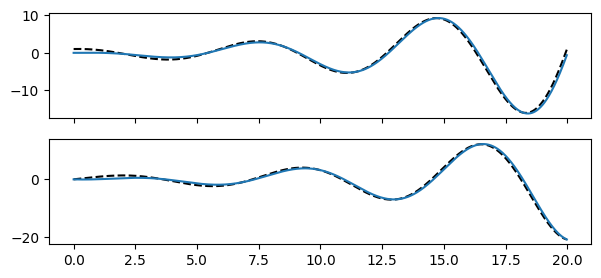

In [315]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
z_plt = z * np.exp(1j * 5*np.pi/4)  # Phase shifted from true state
ax[0].plot(t, np.real(x[:, 0]), 'k--')
ax[0].plot(t, np.real(z_plt[:, 0]))
ax[1].plot(t, np.imag(x[:, 0]), 'k--')
ax[1].plot(t, np.imag(z_plt[:, 0]))
plt.show()

/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


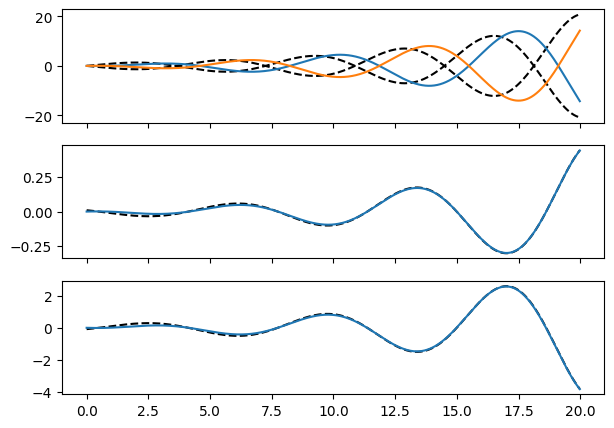

In [316]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.imag(x[:, :2]), 'k--')
ax[0].plot(t, np.imag(z[:, :2].conj()))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z.conj() @ K.T)
plt.show()

# Full LQG

### Explicit forcing control

In [253]:
xC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
Cr @ xC

array([0.64860865-9.94010843e-17j])

In [255]:
Dr

(0.5939506798759142+0j)

In [332]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50.0
n_steps = int(tf // dt)
CL_lqg = np.zeros(n_steps)
CD_lqg = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
u = np.zeros((n_steps, m))  # Control signal
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output

u_proj = np.zeros((n_steps, m))  # Control signal with true projection
y_proj = np.zeros((n_steps, p))  # Estimated output with true projection

# Integrated control signal (this is the BC value)
rho = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_lqg[i], CD_lqg[i] = map(np.real, flow.get_observations())

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Estimate using true projection.. this should match y[i] reasonably well
    # y_est = np.real(Cr @ x[i-1] + Dr * u[i-1])
    y_proj[i] = np.real(Cr @ x[i])  # No feedthrough term here since we are using the homogeneous state

    y[i] = CL_lqg[i]
    if i > 0:
        # y_hat[i] = np.real(C_kf @ (A_kf @ z[i-1] + B_kf @ u[i-1]) + D_kf * u[i-1])
        # z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # # No feedthrough term here since we are using the homogeneous state
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # LQR control
        u_proj[i] = np.real(K @ x[i])

        u[i] = np.real(K @ -z[i].conj())  # <-- conjugate??

        # # Small integral control applied to the actuation to
        # # drive the BC value to zero
        # u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])

        rho[i] = rho[i-1] - dt * u[i]

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqg[i]:.4f}, CD={CD_lqg[i]:.4f}")
        print(f"\tu={u[i]}, u_proj={u_proj[i]}, rho={rho[i]}\n\ty_hat={y_hat[i]} y_proj={y_proj[i]}")

t=0.00, CL=0.0098, CD=-0.0000
	u=[0.], u_proj=[0.], rho=0.0
	y_hat=[0.] y_proj=[0.01003685]
t=0.01, CL=0.0096, CD=-0.0000
	u=[0.00049619], u_proj=[-0.08217874], rho=-4.96188909734153e-06
	y_hat=[0.] y_proj=[0.01021473]
t=0.02, CL=0.0095, CD=-0.0000
	u=[0.00097891], u_proj=[-0.08075962], rho=-1.4750986310653858e-05
	y_hat=[5.82216835e-05] y_proj=[0.01041146]
t=0.03, CL=0.0093, CD=-0.0000
	u=[0.001448], u_proj=[-0.07929651], rho=-2.9230990618537276e-05
	y_hat=[0.00012219] y_proj=[0.01061873]
t=0.04, CL=0.0092, CD=-0.0000
	u=[0.00190344], u_proj=[-0.07781323], rho=-4.8265431864658075e-05
	y_hat=[0.00019223] y_proj=[0.01083375]
t=0.05, CL=0.0090, CD=-0.0000
	u=[0.00234528], u_proj=[-0.07631772], rho=-7.171823215949929e-05
	y_hat=[0.00026809] y_proj=[0.01105552]
t=0.06, CL=0.0089, CD=-0.0000
	u=[0.00277356], u_proj=[-0.07481266], rho=-9.945387656043227e-05
	y_hat=[0.00034954] y_proj=[0.01128363]
t=0.07, CL=0.0087, CD=-0.0000
	u=[0.00318836], u_proj=[-0.07329896], rho=-0.00013133745760892507

KeyboardInterrupt: 

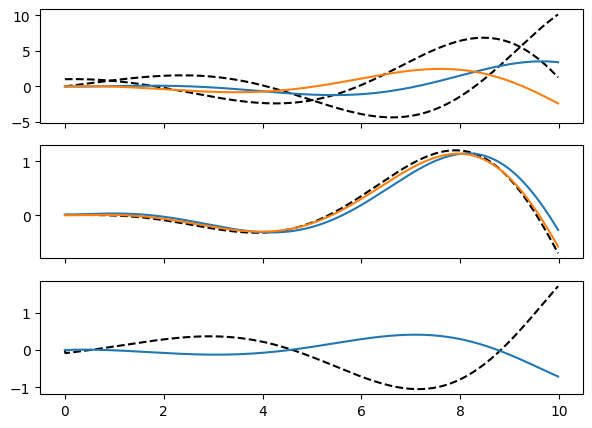

In [331]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, 0]), 'k--')
ax[0].plot(t, np.imag(x[:, 0]), 'k--')
ax[0].plot(t, -np.real(z[:, 0]))
ax[0].plot(t, np.imag(z[:, 0]))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_proj)
ax[1].plot(t, y_hat)
ax[2].plot(t, u_proj, 'k--')
ax[2].plot(t, u)
plt.show()